# Capital One Data Science Challenge
Workday ID C973060  
JTN

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## Question 1
Programatically download and load the trip data for September 2015.  
Report how many rows and columns of data you have loaded.

In [2]:
trips = pd.read_csv('green_tripdata_2015-09.csv')
n_rows, n_cols = trips.shape
print("Rows: {}, Cols: {}".format(n_rows, n_cols))

Rows: 1494926, Cols: 21


In [3]:
list(trips)

['VendorID',
 'lpep_pickup_datetime',
 'Lpep_dropoff_datetime',
 'Store_and_fwd_flag',
 'RateCodeID',
 'Pickup_longitude',
 'Pickup_latitude',
 'Dropoff_longitude',
 'Dropoff_latitude',
 'Passenger_count',
 'Trip_distance',
 'Fare_amount',
 'Extra',
 'MTA_tax',
 'Tip_amount',
 'Tolls_amount',
 'Ehail_fee',
 'improvement_surcharge',
 'Total_amount',
 'Payment_type',
 'Trip_type ']

## Cleaning Data
Remove all trips with a negative or zero fare.  
Remove the Ehail fee since it's mostly missing.

In [34]:
trips = trips[trips['Fare_amount'] > 0]
if 'Ehail_fee' in trips:
    trips = trips.drop('Ehail_fee', axis='columns')
print(trips.shape)

(1488041, 21)


## Question 2
Plot a histogram of the number of trip distance.  
Report any structure you find and any hypotheses you have about that structure.

*The number of trips seems to decay exponentially with the trip distance, or follow a log-normal distribution. 
This is probably because people tend to travel short distances quite frequently,
and they're more likely to drive the farther away it is to save money.*

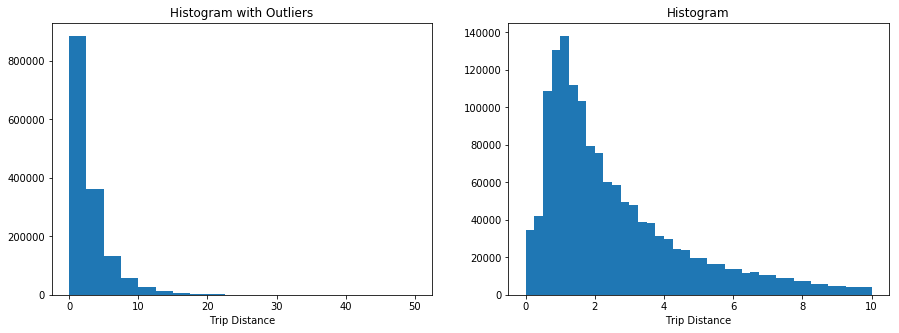

In [5]:
trip_distance = trips['Trip_distance']

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(trip_distance, bins=20, range=(0,50))
axs[0].set_xlabel("Trip Distance")
axs[0].set_title("Histogram with Outliers")
axs[1].hist(trip_distance, bins=40, range=(0,10))
axs[1].set_xlabel("Trip Distance")
axs[1].set_title("Histogram")
plt.show()

## Question 3
Report mean and median trip distance grouped by hour of day.  
We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC
airports. Provide a count of how many transactions fit this criteria, the average fare, and any
other interesting characteristics of these trips.

Using https://stackoverflow.com/questions/16266019/python-pandas-group-datetime-column-into-hour-and-minute-aggregations  
*The first approach I took was to define a circle of radius 0.01 (latitude/longitude units) around each airport, then filter by each trip's start and stop destination. Further improvement would be to map out the actual pickup areas around each airport and filter by that.*

Using http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf  
*The second approach I took was noticing that RateCodeID of `2` or `3` corresponds to JFK and Newark Airports. This seems more promising than drawing a manual radius.*

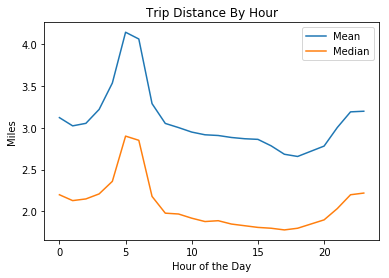

hour 0: mean 3.121, median 2.200
hour 1: mean 3.023, median 2.130
hour 2: mean 3.053, median 2.150
hour 3: mean 3.219, median 2.210
hour 4: mean 3.534, median 2.360
hour 5: mean 4.140, median 2.900
hour 6: mean 4.060, median 2.850
hour 7: mean 3.288, median 2.180
hour 8: mean 3.052, median 1.980
hour 9: mean 3.002, median 1.970
hour 10: mean 2.948, median 1.920
hour 11: mean 2.916, median 1.880
hour 12: mean 2.907, median 1.890
hour 13: mean 2.884, median 1.850
hour 14: mean 2.869, median 1.830
hour 15: mean 2.861, median 1.810
hour 16: mean 2.784, median 1.800
hour 17: mean 2.683, median 1.780
hour 18: mean 2.657, median 1.800
hour 19: mean 2.719, median 1.850
hour 20: mean 2.781, median 1.900
hour 21: mean 3.003, median 2.035
hour 22: mean 3.190, median 2.200
hour 23: mean 3.197, median 2.220


In [6]:
times = pd.DatetimeIndex(trips['lpep_pickup_datetime'])
hours = trips.groupby([times.hour])['Trip_distance']
    
t = hours.groups.keys()
plt.plot(t, hours.mean(), label="Mean")
plt.plot(t, hours.median(), label="Median")
plt.legend()
plt.title("Trip Distance By Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Miles")
plt.show()

for hour in hours:
    print("hour {}: mean {:.3f}, median {:.3f}".format(hour[0], hour[1].mean(), hour[1].median()))

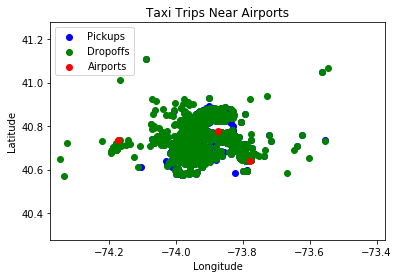

There are 5410 trips with a pickup/dropoff at JFK or Newark.
The average fare of these trips is $51.49.


In [8]:
# These three functions below are not used; they are kept around to show a history of work.
# (the code works, but using the RateCodeID works much better).
def airport_dist(trips, airport):
    """
    Returns:
        dist (float): the distance between each trip and the given airport.
    """
    pickup_dist = np.linalg.norm(trips[['Pickup_longitude', 'Pickup_latitude']] - airport, axis=1)
    dropoff_dist = np.linalg.norm(trips[['Dropoff_longitude', 'Dropoff_latitude']] - airport, axis=1)
    dist = np.minimum(pickup_dist, dropoff_dist)
    return dist

def min_airport_dist(trips, airports):
    """
    Returns:
        dist (float): the minimum distance between each trip and all airports.
    """
    return np.min([
            airport_dist(trips, airport) for airport in airports
        ], axis=0)

def trips_near_airports(trips, airports, epsilon=0.01):
    """
    Returns:
        trips_filtered (dataframe): the trips which are near an airport.
    """
    dist = min_airport_dist(trips, airports)
    trips_filtered = trips.iloc[dist < epsilon]
    return trips_filtered

### Here we have the functional code

def trips_near_airports_v2(trips):
    idx = (trips['RateCodeID'] == 2) | (trips['RateCodeID'] == 3)
    return trips[idx]

# List of (longitude, latitude) tuples
airports = np.array([
    [-73.7781, 40.6413], # JFK
    [-73.8740, 40.7769], # LaGuardia (LGA)
    [-74.1724, 40.7357] # Newark (EWR)
])
lga = airports[1]
display_epsilon = 0.5
filter_epsilon = 0.005
# Filter trips, keeping those near airports
# airport_trips = trips_near_airports(trips, airports, epsilon=filter_epsilon)
airport_trips = trips_near_airports_v2(trips)

# Plot everything
plt.scatter(airport_trips['Pickup_longitude'], airport_trips['Pickup_latitude'], color='blue', label="Pickups")
plt.scatter(airport_trips['Dropoff_longitude'], airport_trips['Dropoff_latitude'], color='green', label="Dropoffs")
plt.scatter(airports[:,0], airports[:,1], color='r', zorder=3, label="Airports")
plt.xlim([lga[0]-display_epsilon, lga[0]+display_epsilon])
plt.ylim([lga[1]-display_epsilon, lga[1]+display_epsilon])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Taxi Trips Near Airports")
plt.show()

# Print results
# print("There are {} trips with a pickup/dropoff within a {} latitude/longitude radius of an airport.".format(
#         airport_trips.shape[0], filter_epsilon))
print("There are {} trips with a pickup/dropoff at JFK or Newark.".format(airport_trips.shape[0]))
print("The average fare of these trips is ${:.2f}.".format(airport_trips['Fare_amount'].mean()))

## Question 4
Build a derived variable for tip as a percentage of the total fare.  
Build a predictive model for tip as a percentage of the total fare. Provide an estimate of
performance using an appropriate sample, and show your work.

Using https://www.analyticsvidhya.com/blog/2015/09/build-predictive-model-10-minutes-python/



In [35]:
# Build a derived variable for tip pecentage
if 'Tip_pct' not in trips:
    trips['Tip_pct'] = trips['Tip_amount'] / trips['Fare_amount']

# Derived predictive model will use `Trip_distance`, `Ehail_fee`, `Payment_type`, `Trip_type `
list(trips)
ID_col = ['VendorID']
target_col = ['Tip_pct']
cat_cols = ['Payment_type', 'Trip_type ']
num_cols = ['Trip_distance', 'Fare_amount']

trips.isnull().any()

VendorID                 False
lpep_pickup_datetime     False
Lpep_dropoff_datetime    False
Store_and_fwd_flag       False
RateCodeID               False
Pickup_longitude         False
Pickup_latitude          False
Dropoff_longitude        False
Dropoff_latitude         False
Passenger_count          False
Trip_distance            False
Fare_amount              False
Extra                    False
MTA_tax                  False
Tip_amount               False
Tolls_amount             False
improvement_surcharge    False
Total_amount             False
Payment_type             False
Trip_type                 True
Tip_pct                  False
dtype: bool

Here we see that `Payment_type` is a clear indicator of whether or not there was a tip.  
Let's filter out data by that.

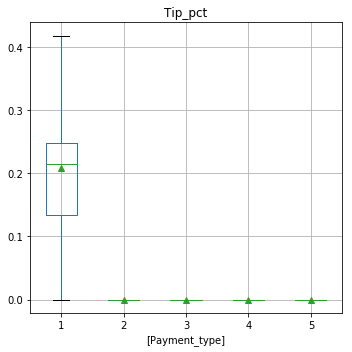

In [66]:
fig, ax = plt.subplots(1, figsize=(5,5))
trips.boxplot(['Tip_pct'], by=['Payment_type'], ax=ax, showfliers=False, showmeans=True)

plt.tight_layout()
plt.suptitle("")
plt.show()

Filter out by credit cards payment type.

In [58]:
trips_cc = trips[trips['Payment_type'] == 1]
trips_cc['Tip_pct'].describe()

count    700797.000000
mean          0.208912
std           0.581327
min           0.000000
25%           0.133333
50%           0.215238
75%           0.247273
max         150.000000
Name: Tip_pct, dtype: float64

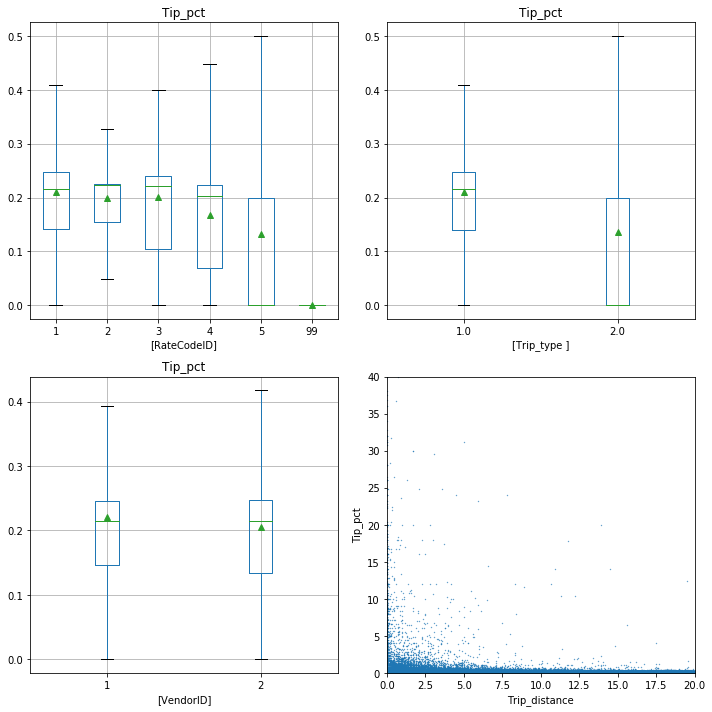

In [74]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()
trips_cc.boxplot(['Tip_pct'], by=['RateCodeID'], ax=axs[0], showfliers=False, showmeans=True)
trips_cc.boxplot(['Tip_pct'], by=['Trip_type '], ax=axs[1], showfliers=False, showmeans=True)
trips_cc.boxplot(['Tip_pct'], by=['VendorID'], ax=axs[2], showfliers=False, showmeans=True)
trips_cc.plot.scatter('Trip_distance', 'Tip_pct', ax=axs[3], xlim=[0,20], ylim=[0,40], s=0.1)

plt.tight_layout()
plt.suptitle("")
plt.show()

## Feature Engineering
Add a `Trip_time` category. Does a shorter trip mean a happier customer who tips generously?

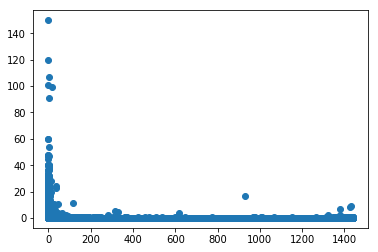

In [101]:
trips['Hour'] = pd.to_datetime(trips['lpep_pickup_datetime']).dt.hour
time_diff = (pd.to_datetime(trips['Lpep_dropoff_datetime']) - pd.to_datetime(trips['lpep_pickup_datetime']))
trips['Trip_time'] = time_diff / pd.Timedelta(minutes=1)
plt.scatter(trips['Trip_time'], trips['Tip_pct'])
plt.show()

In [84]:
stats.linregress(trips['Trip_time'], trips['Tip_pct'])

LinregressResult(slope=-2.951970336180711e-05, intercept=0.09902726451573796, rvalue=-0.0068935734016729484, pvalue=4.126827109605822e-17, stderr=3.5103474820793333e-06)

There appears to be no linear relationship between trip length and tip percentage.  
What about between average speed and tip percentage?

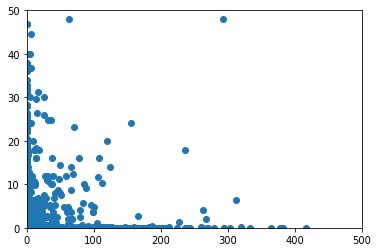

In [91]:
trips_nonzero = trips[trips['Trip_time'] != 0]
avg_speed = trips_nonzero['Trip_distance'] / trips_nonzero['Trip_time']
plt.scatter(avg_speed, trips_nonzero['Tip_pct'])
plt.xlim([0,500])
plt.ylim([0,50])
plt.show()

In [92]:
stats.linregress(avg_speed, trips_nonzero['Tip_pct'])

LinregressResult(slope=0.003498947561247111, intercept=0.09756373560091582, rvalue=0.030259964586644674, pvalue=3.342666518319552e-298, stderr=9.477817230260759e-05)

There appears to be no linear relationship here either.

## Building a Predictive Model
Since most of the predictive power seems to come from categorical variables, we will use a decision tree.  

In [40]:
reg = DecisionTreeRegressor(max_depth=2)
reg.fit()

False

In [108]:
feature_cols = [
    'RateCodeID',
    'Hour',
    'Pickup_longitude',
    'Pickup_latitude',
    'Dropoff_longitude',
    'Dropoff_latitude',
    'Passenger_count',
    'Trip_distance',
    'Fare_amount',
    'Trip_type ',
    'Trip_time'
]
X_train, X_test, y_train, y_test = train_test_split(
    trips[feature_cols], trips['Tip_pct'], train_size=5, test_size=5)

reg = DecisionTreeRegressor(max_depth=1)
reg.fit(X_train, y_train)
print("score: {}".format(reg.score(X_test, y_test)))
# rf = RandomForestClassifier(n_estimators=1)
# rf.fit(X_train, y_train)

score: -11.765744897959179


In [93]:
list(trips)

['VendorID',
 'lpep_pickup_datetime',
 'Lpep_dropoff_datetime',
 'Store_and_fwd_flag',
 'RateCodeID',
 'Pickup_longitude',
 'Pickup_latitude',
 'Dropoff_longitude',
 'Dropoff_latitude',
 'Passenger_count',
 'Trip_distance',
 'Fare_amount',
 'Extra',
 'MTA_tax',
 'Tip_amount',
 'Tolls_amount',
 'improvement_surcharge',
 'Total_amount',
 'Payment_type',
 'Trip_type ',
 'Tip_pct',
 'Trip_time']